In [1]:
#Import necessary modules
%matplotlib inline
#graphical figure representations
import matplotlib.pyplot as plt

#data preprocessing
import numpy as np
import pandas as pd
#join ham part 1 and 2 together
import os
from tqdm import tqdm
from glob import glob
import itertools
#read images
import cv2

#data splits and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample

#model creation and training
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#join both folders into a single dictionary
BASE_SKIN_DATASET = os.path.join("../../../../../Skin Cancer Stuff/datasets/HAM10000")

ALL_IMAGE_PATH_MAP = {os.path.splitext(os.path.basename(x))[0]: x
                         for x in glob(os.path.join(BASE_SKIN_DATASET, '*', '*.jpg'))
                     }

#Fix the path (#WindowsProblems)
for k, v in ALL_IMAGE_PATH_MAP.items():
    a = ALL_IMAGE_PATH_MAP[k].replace("\\\\", "/")
    a = a.replace("\\", "/")
    ALL_IMAGE_PATH_MAP[k] = a

#Easy mapping
LESION_MAP = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
len(ALL_IMAGE_PATH_MAP)

10015

In [4]:
#read-in csv
data = pd.read_csv(BASE_SKIN_DATASET + "/HAM10000_metadata.csv")

In [5]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
#create more reader friendly columns
data['path'] = data['image_id'].map(ALL_IMAGE_PATH_MAP.get)
data['lesion_type'] = data['dx'].map(LESION_MAP.get) 
data['lesion_type_index'] = pd.Categorical(data['lesion_type']).codes

In [7]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,lesion_type,lesion_type_index
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../../../../../Skin Cancer Stuff/datasets/HAM1...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../../../../../Skin Cancer Stuff/datasets/HAM1...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../../../../../Skin Cancer Stuff/datasets/HAM1...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../../../../../Skin Cancer Stuff/datasets/HAM1...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../../../../../Skin Cancer Stuff/datasets/HAM1...,Benign keratosis-like lesions,2


In [8]:
data['lesion_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_type, dtype: int64

<AxesSubplot:>

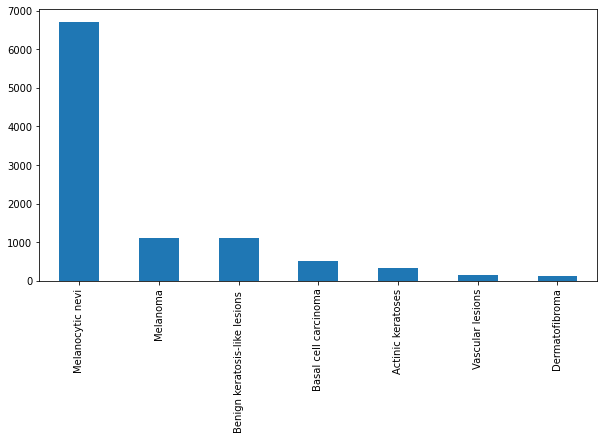

In [9]:
#Visualize data distribution
figure, axis_1 = plt.subplots(1, 1, figsize= (10, 5))
data['lesion_type'].value_counts().plot(kind='bar', ax=axis_1)

In [10]:
def balanced_dataset(df):
    '''
        will sample the dataset, such that the classes
        with less samples are given similar importance
        to the more sampled ones
    '''
    df_balanced = pd.DataFrame()
    
    for cat in df['lesion_type_index'].unique():
        #sample dataset, due to unbalanceness
        #sample it to match majority class
        temp = resample(df[df['lesion_type_index'] == cat], 
                        replace=True,     
                        n_samples=7000,   
                        random_state=123) 

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['lesion_type'].value_counts()

    return df_balanced

In [11]:
#load all images, and normalize
def load_img_data(size, df, balanced=False):   
    '''
    load, scale/normalize, all images
    '''
    img_height, img_width = size, size
    images = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    #a progress indicator
    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_height, img_width))
        img = img.astype(np.float32) / 255.
        images.append(img)

    images = np.stack(images, axis=0)
    print(images.shape)    
    return images, df['lesion_type_index'].values

In [12]:
input_images, ground_truths = load_img_data(128, data, balanced=False)

100%|██████████| 10015/10015 [14:38<00:00, 11.40it/s]


(10015, 128, 128, 3)


In [13]:
#split data into train, validation and test (for training and evaluation)

x_train, x_test, y_train, y_test = train_test_split(input_images, ground_truths, test_size=0.25, random_state = 10)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2, random_state = 11)
train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

[(7511, 128, 128, 3), (501, 128, 128, 3), (2003, 128, 128, 3)]

In [41]:
#Program Brain
class ModelBrain():
    def __init__(self, data, hidden_layers, classes, epochs, batch_size):
        '''
        constructor, initializes values on ModelBrain object creation
        '''
        self.input_shape = data[0][0].shape
        self.hidden_layers = hidden_layers
        self.classes = classes
        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size
        
        self.dcnn = self.get_network()
        self.dcnn.trainable = False

        #grab the values from the tuple
        self.trainX = data[0]
        self.trainY = data[1]
        self.valX = data[2]
        self.valY = data[3]
        self.testX = data[4]
        self.testY = data[5]

        self.model = self.build_model()
        self.train_generator = self.data_augmentation()
        
        self.predictions = None
        self.score = None
        self.best_weights = None

    def data_augmentation(self):
        data_gen_args = dict(
                rotation_range=10,
                zoom_range=0.1,
                shear_range=0.1,
                width_shift_range=0.1, 
                height_shift_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
            )

        train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)
        return train_generator
        
    def get_network(self):
        return tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=self.input_shape)

    def build_model(self):
        model = tf.keras.models.Sequential()
        model.add(self.dcnn)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.25))
        
        for layer in self.hidden_layers:
            model.add(tf.keras.layers.Dense(layer, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(0.46))  

        model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))
        return model
    
    def load_weights(self, name):
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)
        
    def predict(self):
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.testX, self.testY, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.testX, batch_size=self.BATCH_SIZE)
        print('Done')

    def train(self):
        numTrainingSamples = self.trainX.shape[0]
        numValidationSamples = self.valX.shape[0]

        #Phase 01#
        print ("\nPhase A - Training Fully Connected Layers\n")
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

        best_weights_ph1 = "ph1_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
        
        history = self.model.fit(
            x_train, y_train,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            callbacks=[checkpoint])
        
        best_acc_ph1 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph1)
        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)    
        self.predict()       


        #Phase 2#
        print ("\nPhase B  - Fine Tuned Layers \n")
        #freeze all but last 4 layers
        for layer in self.model.layers[:-4]:
            layer.trainable = False

        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])
        best_weights_ph2 = "ph2_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

        history = self.model.fit(
            x_train, y_train,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            callbacks=[checkpoint])

        # Store the best phase 2 accuracy
        best_acc_ph2 = max(history.history["val_accuracy"])
        
    def run(self):
        self.train()

In [26]:
#Random arbitrary values
HIDDEN_LAYERS = [512, 128]
BATCH_SIZE_REGULAR = 128
BATCH_SIZE_DCNN = 96
EPOCHS = 10
#ground truth possible classes
CLASSES = len(set(ground_truths))

#Training phase
model = ModelBrain(train_val_test, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE_DCNN)
model.run()


Phase A - Training Fully Connected Layers


Restoring best weights and predicting validation set.

Loading best accuracy weights.

Predicting test set classes.
Test set score: [0.4054315388202667, 0.8562156558036804]
Done

Phase B  - Fine Tune all Layers 

Epoch 1/10
78/78 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.8107
Epoch 00001: val_loss improved from inf to 0.37547, saving model to _ph2_weights.hdf5
78/78 [==============================] - 304s 4s/step - loss: 0.5608 - accuracy: 0.8107 - val_loss: 0.3755 - val_accuracy: 0.8643
Epoch 2/10
78/78 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.8104
Epoch 00002: val_loss improved from 0.37547 to 0.37193, saving model to _ph2_weights.hdf5
78/78 [==============================] - 302s 4s/step - loss: 0.5635 - accuracy: 0.8104 - val_loss: 0.3719 - val_accuracy: 0.8703
Epoch 3/10
78/78 [==============================] - ETA: 0s - loss: 0.5439 - accuracy: 0.8080
Epoch 00003: val_loss im

# Evaluation of Models

In [14]:
model_p1 = keras.models.load_model("ph1_weights.hdf5")
predictions_p1 = model_p1.predict(train_val_test[4])
model_p2 = keras.models.load_model("ph2_weights.hdf5")
predictions_p2 = model_p2.predict(train_val_test[4])

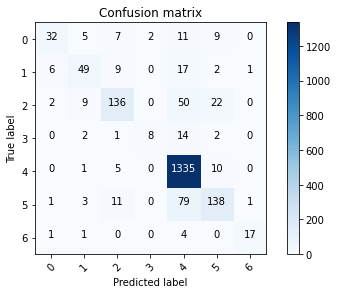

In [67]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    from shared code available on Kaggle
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# one hot encode predictions 
Y_pred_classes_p1 = np.argmax(predictions_p1,axis = 1)
Y_pred_classes_p2 = np.argmax(predictions_p2,axis = 1) 
# compute the confusion matrix
confusion_mtx_p1 = confusion_matrix(y_test, Y_pred_classes_p1)
confusion_mtx_p2 = confusion_matrix(y_test, Y_pred_classes_p2)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_p1, classes = range(7))

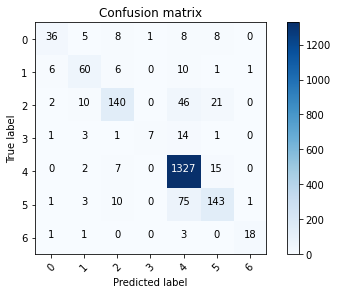

In [68]:
plot_confusion_matrix(confusion_mtx_p2, classes = range(7))

In [69]:
print(classification_report(Y_pred_classes_p1, y_test))

              precision    recall  f1-score   support

           0       0.48      0.76      0.59        42
           1       0.58      0.70      0.64        70
           2       0.62      0.80      0.70       169
           3       0.30      0.80      0.43        10
           4       0.99      0.88      0.93      1510
           5       0.59      0.75      0.66       183
           6       0.74      0.89      0.81        19

    accuracy                           0.86      2003
   macro avg       0.62      0.80      0.68      2003
weighted avg       0.89      0.86      0.87      2003



In [71]:
print(classification_report(Y_pred_classes_p2, y_test))

              precision    recall  f1-score   support

           0       0.55      0.77      0.64        47
           1       0.71      0.71      0.71        84
           2       0.64      0.81      0.72       172
           3       0.26      0.88      0.40         8
           4       0.98      0.89      0.94      1483
           5       0.61      0.76      0.68       189
           6       0.78      0.90      0.84        20

    accuracy                           0.86      2003
   macro avg       0.65      0.82      0.70      2003
weighted avg       0.89      0.86      0.87      2003



# Phase 2 model has better metrics

# Percentage predictions

In [15]:
#7 classes, each have their probabilities
#in this case the 0th class has the highest one
#hence this prediction is of class 0

INDEX_TO_TYPE = {
    0: 'Melanocytic nevi',
    1: 'Melanoma',
    2: 'Benign keratosis-like lesions ',
    3: 'Basal cell carcinoma',
    4: 'Actinic keratoses',
    5: 'Vascular lesions',
    6: 'Dermatofibroma'
}

test_predictions = predictions_p2[0]
test_predictions = test_predictions * 100
str(np.amax(test_predictions)) + f"% {INDEX_TO_TYPE[np.argmax(test_predictions)]}" 

'98.745026% Actinic keratoses'